# Phase 5 Capstone

# Predicting Obesity/ Obesity Prediction

- Student name: Lucas Wilkerson
- Student pace: Flex/part time
- Scheduled project review date/time:
- Instructor name: Morgan Jones

## Business Understanding 

## Data Understanding 

## Data Preparation

## Modeling

## Evaluation

## Deployment

In [1]:
# Importing standard Packages 
import pandas as pd
import numpy as np
import math 
import zipfile

# Importing packages for visualization 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

# Importing packages for statistics
import statsmodels.api as sm
import sklearn.metrics as metrics
from scipy import stats
from scipy.stats import kstest
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import RocCurveDisplay, confusion_matrix, classification_report, make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_curve, auc
from sklearn.metrics import log_loss, ConfusionMatrixDisplay
#from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import (VarianceThreshold, SelectKBest, f_regression, mutual_info_regression, 
    RFE, RFECV)
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

import os


In [2]:
# Function to load dataset 

def load_csv_from_zip(zip_file_path, csv_file_name):
    
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Check if the CSV file exists in the zip file
        if csv_file_name in zip_ref.namelist():
            # Read the CSV file directly into a DataFrame
            with zip_ref.open(csv_file_name) as csv_file:
                df = pd.read_csv(csv_file)
                return df
        else:
            print(f"CSV file '{csv_file_name}' not found in the zip file.")
            return None

zip_file_path = "data/brfss2022.csv.zip"
csv_file_name = "brfss2022.csv"
df = load_csv_from_zip(zip_file_path, csv_file_name)
if df is not None:
    print("CSV file loaded successfully!")
    print(df.head())  # Display the first few rows of the DataFrame

CSV file loaded successfully!
   _STATE  FMONTH    IDATE  IMONTH  IDAY  IYEAR  DISPCODE       SEQNO  \
0     1.0     1.0  2032022       2     3   2022    1100.0  2022000001   
1     1.0     1.0  2042022       2     4   2022    1100.0  2022000002   
2     1.0     1.0  2022022       2     2   2022    1100.0  2022000003   
3     1.0     1.0  2032022       2     3   2022    1100.0  2022000004   
4     1.0     1.0  2022022       2     2   2022    1100.0  2022000005   

           _PSU  CTELENM1  ...  _SMOKGRP  _LCSREC  DRNKANY6      DROCDY4_  \
0  2.022000e+09       1.0  ...       4.0      NaN       2.0  5.397605e-79   
1  2.022000e+09       1.0  ...       4.0      NaN       2.0  5.397605e-79   
2  2.022000e+09       1.0  ...       4.0      NaN       2.0  5.397605e-79   
3  2.022000e+09       1.0  ...       3.0      2.0       2.0  5.397605e-79   
4  2.022000e+09       1.0  ...       4.0      NaN       1.0  1.000000e+01   

   _RFBING6      _DRNKWK2  _RFDRHV8  _FLSHOT7  _PNEUMO3  _AIDTST4  


In [3]:
# Previewing df shape
df.shape

(445132, 326)

In [4]:
#Printing out the total number of rows and columns in the BRFSS dataset
n_rows, n_cols = df.shape
print('The number of rows in the dataset is', n_rows)
print('The number of columns in the dataset is', n_cols)

The number of rows in the dataset is 445132
The number of columns in the dataset is 326


In [5]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)


In [6]:
# Previewing general information on dataset
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Columns: 326 entries, _STATE to _AIDTST4
dtypes: float64(321), int64(5)
memory usage: 1.1 GB
None


Looking at the initial dataset information, this dataset contains 445132 entries with a total of 326 columns with datatypes being integers and floats. While there are some numerical columns, a good amount of the columns are categoricla/numerical. The many columns represent  various health-related risk behaviors, chronic health conditions, demographics, location, and even the use of preventive services along with other variables. I plan to narrow down the columns for the dataset, choosing the ones relevant for this analysis. 

In [7]:
#Selecting a subset of relevant columns out of the 326 variables in the data for exploratory analysis----------------------
col_selected = [ #Record Identification/ Demographics----------------------------------------------------------------------
            '_STATE', 'NUMADULT', '_SEX', '_AGEG5YR', '_AGE80', '_AGE_G', 'MARITAL','_EDUCAG', '_INCOMG1', 
            'VETERAN3', 'EMPLOY1', '_CHLDCNT', '_METSTAT', '_URBSTAT', '_IMPRACE', '_RACE1', '_RACEPR1', '_HISPANC', 
                #Health Status/ Metrics------------------------------------------------------------------------------------
            'WEIGHT2', 'WTKG3', 'HEIGHT3', 'HTIN4', 'HTM4', '_BMI5', '_BMI5CAT', '_RFBMI5', 
            'GENHLTH', '_RFHLTH','PHYSHLTH', '_PHYS14D',
            'MENTHLTH', '_MENT14D', 'POORHLTH', 'EXERANY2', '_TOTINDA', 'SLEPTIM1', 
            '_HLTHPLN', 'PERSDOC3', 'CHECKUP1', 'ADDEPEV3', 'HAVARTH4', '_DRDXAR2', '_MICHD',  
            'DIABETE4', 'PDIABTS1', 'PREDIAB2', 'DECIDE',  
                #Tobacco use-----------------------------------------------------------------------------------------------
            '_SMOKER3', 'SMOKDAY2','SMOKE100', 'USENOW3', 'ECIGNOW2', '_CURECI2', 
                #Alcohol consumption---------------------------------------------------------------------------------------
            'DRNK3GE5', 'DRNKANY6', '_RFBING6', '_DRNKWK2',
                #Social determinants/Health Equity 
            'LSATISFY', 'EMTSUPRT', 'SDHISOLT', 'SDHEMPLY', 'FOODSTMP', 'SDHFOOD1', 'SDHBILLS', 'SDHUTILS',
            'SDHTRNSP', 'SDHSTRE1']

In [8]:
#Computing basic statistics on the selected variables---------------------------------------------------------------------
df_subset = df[col_selected].copy()
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 67 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    445132 non-null  float64
 1   NUMADULT  96032 non-null   float64
 2   _SEX      445132 non-null  float64
 3   _AGEG5YR  445132 non-null  float64
 4   _AGE80    445132 non-null  float64
 5   _AGE_G    445132 non-null  float64
 6   MARITAL   445124 non-null  float64
 7   _EDUCAG   445132 non-null  float64
 8   _INCOMG1  445132 non-null  float64
 9   VETERAN3  440959 non-null  float64
 10  EMPLOY1   438936 non-null  float64
 11  _CHLDCNT  445131 non-null  float64
 12  _METSTAT  435724 non-null  float64
 13  _URBSTAT  435724 non-null  float64
 14  _IMPRACE  445132 non-null  float64
 15  _RACE1    445130 non-null  float64
 16  _RACEPR1  445132 non-null  float64
 17  _HISPANC  445132 non-null  float64
 18  WEIGHT2   429231 non-null  float64
 19  WTKG3     403054 non-null  float64
 20  HEIG

In [9]:
#Previewing first 10 rows 
df_subset.head(10)


,_STATE,NUMADULT,_SEX,_AGEG5YR,_AGE80,_AGE_G,MARITAL,_EDUCAG,_INCOMG1,VETERAN3,EMPLOY1,_CHLDCNT,_METSTAT,_URBSTAT,_IMPRACE,_RACE1,_RACEPR1,_HISPANC,WEIGHT2,WTKG3,HEIGHT3,HTIN4,HTM4,_BMI5,_BMI5CAT,_RFBMI5,GENHLTH,_RFHLTH,PHYSHLTH,_PHYS14D,MENTHLTH,_MENT14D,POORHLTH,EXERANY2,_TOTINDA,SLEPTIM1,_HLTHPLN,PERSDOC3,CHECKUP1,ADDEPEV3,HAVARTH4,_DRDXAR2,_MICHD,DIABETE4,PDIABTS1,PREDIAB2,DECIDE,_SMOKER3,SMOKDAY2,SMOKE100,USENOW3,ECIGNOW2,_CURECI2,DRNK3GE5,DRNKANY6,_RFBING6,_DRNKWK2,LSATISFY,EMTSUPRT,SDHISOLT,SDHEMPLY,FOODSTMP,SDHFOOD1,SDHBILLS,SDHUTILS,SDHTRNSP,SDHSTRE1
0,1.0,2.0,2.0,13.0,80.0,6.0,1.0,4.0,9.0,2.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,9999.0,NaN,9999.0,NaN,NaN,NaN,NaN,9.0,2.0,1.0,88.0,1.0,88.0,1.0,NaN,2.0,2.0,8.0,9.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,NaN,NaN,2.0,4.0,NaN,2.0,3.0,4.0,1.0,NaN,2.0,1.0,5.397605e-79,1.0,1.0,5.0,2.0,2.0,5.0,2.0,2.0,2.0,4.0
1,1.0,2.0,2.0,13.0,80.0,6.0,3.0,2.0,3.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,150.0,6804.0,503.0,63.0,160.0,2657.0,3.0,2.0,1.0,1.0,88.0,1.0,88.0,1.0,NaN,2.0,2.0,6.0,1.0,2.0,8.0,2.0,2.0,2.0,2.0,3.0,NaN,NaN,2.0,4.0,NaN,2.0,3.0,1.0,1.0,NaN,2.0,1.0,5.397605e-79,1.0,1.0,5.0,2.0,2.0,5.0,2.0,2.0,2.0,5.0
2,1.0,1.0,2.0,8.0,56.0,5.0,1.0,4.0,6.0,2.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,140.0,6350.0,502.0,62.0,157.0,2561.0,3.0,2.0,2.0,1.0,2.0,2.0,3.0,2.0,2.0,1.0,1.0,5.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,NaN,NaN,2.0,4.0,NaN,2.0,3.0,1.0,1.0,NaN,2.0,1.0,5.397605e-79,2.0,2.0,3.0,2.0,2.0,5.0,2.0,2.0,2.0,5.0
3,1.0,3.0,2.0,14.0,73.0,6.0,1.0,2.0,9.0,2.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,140.0,6350.0,505.0,65.0,165.0,2330.0,2.0,1.0,1.0,1.0,88.0,1.0,88.0,1.0,NaN,1.0,1.0,7.0,9.0,1.0,1.0,2.0,1.0,1.0,2.0,3.0,NaN,NaN,2.0,2.0,2.0,1.0,3.0,1.0,1.0,NaN,2.0,1.0,5.397605e-79,1.0,1.0,3.0,2.0,2.0,5.0,2.0,2.0,2.0,5.0
4,1.0,2.0,2.0,5.0,43.0,3.0,1.0,3.0,3.0,2.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,119.0,5398.0,502.0,62.0,157.0,2177.0,2.0,1.0,4.0,2.0,2.0,2.0,88.0,1.0,88.0,1.0,1.0,9.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,NaN,NaN,2.0,4.0,NaN,2.0,3.0,1.0,1.0,88.0,1.0,1.0,1.400000e+02,1.0,1.0,5.0,2.0,2.0,5.0,2.0,2.0,2.0,5.0
5,1.0,1.0,1.0,13.0,80.0,6.0,1.0,2.0,9.0,2.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,187.0,8482.0,511.0,71.0,180.0,2608.0,3.0,2.0,5.0,2.0,1.0,2.0,88.0,1.0,88.0,2.0,2.0,7.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,NaN,NaN,2.0,4.0,NaN,2.0,3.0,1.0,1.0,NaN,2.0,1.0,5.397605e-79,2.0,2.0,5.0,2.0,2.0,5.0,2.0,2.0,2.0,5.0
6,1.0,1.0,2.0,13.0,80.0,6.0,2.0,4.0,5.0,2.0,7.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,138.0,6260.0,505.0,65.0,165.0,2296.0,2.0,1.0,2.0,1.0,88.0,1.0,88.0,1.0,NaN,1.0,1.0,7.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,NaN,NaN,2.0,3.0,3.0,1.0,3.0,1.0,1.0,88.0,1.0,1.0,2.330000e+02,1.0,1.0,4.0,2.0,2.0,5.0,2.0,2.0,2.0,5.0
7,1.0,1.0,2.0,13.0,80.0,6.0,3.0,2.0,5.0,2.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,162.0,7348.0,504.0,64.0,163.0,2781.0,3.0,2.0,3.0,1.0,88.0,1.0,88.0,1.0,NaN,2.0,2.0,8.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,3.0,NaN,NaN,2.0,4.0,NaN,2.0,3.0,1.0,1.0,NaN,2.0,1.0,5.397605e-79,1.0,1.0,5.0,2.0,2.0,5.0,2.0,2.0,2.0,5.0
8,1.0,2.0,2.0,12.0,78.0,6.0,1.0,4.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,9999.0,NaN,507.0,67.0,170.0,NaN,NaN,9.0,3.0,1.0,88.0,1.0,88.0,1.0,NaN,1.0,1.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,3.0,NaN,NaN,2.0,3.0,3.0,1.0,3.0,4.0,1.0,NaN,2.0,1.0,5.397605e-79,1.0,1.0,4.0,1.0,2.0,5.0,2.0,2.0,2.0,5.0
9,1.0,2.0,2.0,11.0,72.0,6.0,1.0,4.0,5.0,2.0,7.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,180.0,8165.0,506.0,66.0,168.0,2905.0,3.0,2.0,3.0,1.0,1.0,2.0,88.0,1.0,2.0,1.0,1.0,7.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,NaN,NaN,2.0,4.0,NaN,2.0,3.0,1.0,1.0,88.0,1.0,1.0,2.300000e+01,1.0,1.0,4.0,2.0,2.0,5.0,2.0,2.0,2.0,4.0


In [10]:
#Computing percent missing values in each column in the dataset

percent_missing = ((df_subset.isnull() | df_subset.isna()).sum() * 100 / df_subset.index.size).round(2)
missing_value_df = pd.DataFrame({'column_name': df_subset.columns,
                                 'percent_missing': percent_missing})

In [16]:
missing_value_df

,column_name,percent_missing
_STATE,_STATE,0.00
NUMADULT,NUMADULT,78.43
_SEX,_SEX,0.00
_AGEG5YR,_AGEG5YR,0.00
_AGE80,_AGE80,0.00
_AGE_G,_AGE_G,0.00
MARITAL,MARITAL,0.00
_EDUCAG,_EDUCAG,0.00
_INCOMG1,_INCOMG1,0.00
VETERAN3,VETERAN3,0.94


In [12]:
# Previewing columns 
print(df_subset.columns)

Index(['_STATE', 'NUMADULT', '_SEX', '_AGEG5YR', '_AGE80', '_AGE_G', 'MARITAL',
       '_EDUCAG', '_INCOMG1', 'VETERAN3', 'EMPLOY1', '_CHLDCNT', '_METSTAT',
       '_URBSTAT', '_IMPRACE', '_RACE1', '_RACEPR1', '_HISPANC', 'WEIGHT2',
       'WTKG3', 'HEIGHT3', 'HTIN4', 'HTM4', '_BMI5', '_BMI5CAT', '_RFBMI5',
       'GENHLTH', '_RFHLTH', 'PHYSHLTH', '_PHYS14D', 'MENTHLTH', '_MENT14D',
       'POORHLTH', 'EXERANY2', '_TOTINDA', 'SLEPTIM1', '_HLTHPLN', 'PERSDOC3',
       'CHECKUP1', 'ADDEPEV3', 'HAVARTH4', '_DRDXAR2', '_MICHD', 'DIABETE4',
       'PDIABTS1', 'PREDIAB2', 'DECIDE', '_SMOKER3', 'SMOKDAY2', 'SMOKE100',
       'USENOW3', 'ECIGNOW2', '_CURECI2', 'DRNK3GE5', 'DRNKANY6', '_RFBING6',
       '_DRNKWK2', 'LSATISFY', 'EMTSUPRT', 'SDHISOLT', 'SDHEMPLY', 'FOODSTMP',
       'SDHFOOD1', 'SDHBILLS', 'SDHUTILS', 'SDHTRNSP', 'SDHSTRE1'],
      dtype='object')


In [13]:
#Looping to get all column names and data types
for col in df_subset.columns:
    print(f"Column: {col}, Data Type: {df_subset[col].dtype}")

Column: _STATE, Data Type: float64
Column: NUMADULT, Data Type: float64
Column: _SEX, Data Type: float64
Column: _AGEG5YR, Data Type: float64
Column: _AGE80, Data Type: float64
Column: _AGE_G, Data Type: float64
Column: MARITAL, Data Type: float64
Column: _EDUCAG, Data Type: float64
Column: _INCOMG1, Data Type: float64
Column: VETERAN3, Data Type: float64
Column: EMPLOY1, Data Type: float64
Column: _CHLDCNT, Data Type: float64
Column: _METSTAT, Data Type: float64
Column: _URBSTAT, Data Type: float64
Column: _IMPRACE, Data Type: float64
Column: _RACE1, Data Type: float64
Column: _RACEPR1, Data Type: float64
Column: _HISPANC, Data Type: float64
Column: WEIGHT2, Data Type: float64
Column: WTKG3, Data Type: float64
Column: HEIGHT3, Data Type: float64
Column: HTIN4, Data Type: float64
Column: HTM4, Data Type: float64
Column: _BMI5, Data Type: float64
Column: _BMI5CAT, Data Type: float64
Column: _RFBMI5, Data Type: float64
Column: GENHLTH, Data Type: float64
Column: _RFHLTH, Data Type: float

In [14]:
#Inspecting unique values and value counts for all variables
for col in df_subset:
    print(f"{col} - unique values: ")
    print(df_subset[col].unique(), "\n")
    print("------------------------------------")

_STATE - unique values: 
[ 1.  2.  4.  5.  6.  8.  9. 10. 11. 12. 13. 15. 16. 17. 18. 19. 20. 21.
 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39.
 40. 41. 42. 44. 45. 46. 47. 48. 49. 50. 51. 53. 54. 55. 56. 66. 72. 78.] 

------------------------------------
NUMADULT - unique values: 
[ 2.  1.  3.  4.  5. nan  6. 18.  7. 10.  9.  8. 11. 12. 15. 21. 17.] 

------------------------------------
_SEX - unique values: 
[2. 1.] 

------------------------------------
_AGEG5YR - unique values: 
[13.  8. 14.  5. 12. 11. 10.  9.  7.  6.  4.  2.  3.  1.] 

------------------------------------
_AGE80 - unique values: 
[80. 56. 73. 43. 78. 72. 57. 65. 70. 62. 63. 67. 79. 68. 66. 76. 74. 51.
 71. 61. 64. 60. 52. 69. 46. 58. 38. 77. 59. 54. 75. 35. 55. 45. 44. 50.
 47. 53. 40. 49. 28. 30. 48. 41. 42. 36. 31. 33. 27. 26. 29. 34. 20. 19.
 37. 25. 32. 18. 24. 23. 39. 22. 21.] 

------------------------------------
_AGE_G - unique values: 
[6. 5. 3. 4. 2. 1.] 

------------------

In [15]:
# checking for null
pd.set_option('display.max_rows', 500)
print(df_subset.isna().sum())

_STATE           0
NUMADULT    349100
_SEX             0
_AGEG5YR         0
_AGE80           0
_AGE_G           0
MARITAL          8
_EDUCAG          0
_INCOMG1         0
VETERAN3      4173
EMPLOY1       6196
_CHLDCNT         1
_METSTAT      9408
_URBSTAT      9408
_IMPRACE         0
_RACE1           2
_RACEPR1         0
_HISPANC         0
WEIGHT2      15901
WTKG3        42078
HEIGHT3      17055
HTIN4        32476
HTM4         28652
_BMI5        48806
_BMI5CAT     48806
_RFBMI5          0
GENHLTH          3
_RFHLTH          0
PHYSHLTH         5
_PHYS14D         0
MENTHLTH         3
_MENT14D         0
POORHLTH    189386
EXERANY2         2
_TOTINDA         0
SLEPTIM1         3
_HLTHPLN         0
PERSDOC3         2
CHECKUP1         3
ADDEPEV3         7
HAVARTH4         3
_DRDXAR2      2633
_MICHD        5021
DIABETE4         3
PDIABTS1    304884
PREDIAB2    304910
DECIDE       20986
_SMOKER3         0
SMOKDAY2    281079
SMOKE100     31777
USENOW3      32600
ECIGNOW2     33579
_CURECI2    

In [17]:
# Dropping these columns due to them having over 50% missing data
df_dropped = df_subset.drop(columns= ["DRNK3GE5", "PDIABTS1", "PREDIAB2",
                                      "NUMADULT", "SMOKDAY2"],  axis= 1 )
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 62 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    445132 non-null  float64
 1   _SEX      445132 non-null  float64
 2   _AGEG5YR  445132 non-null  float64
 3   _AGE80    445132 non-null  float64
 4   _AGE_G    445132 non-null  float64
 5   MARITAL   445124 non-null  float64
 6   _EDUCAG   445132 non-null  float64
 7   _INCOMG1  445132 non-null  float64
 8   VETERAN3  440959 non-null  float64
 9   EMPLOY1   438936 non-null  float64
 10  _CHLDCNT  445131 non-null  float64
 11  _METSTAT  435724 non-null  float64
 12  _URBSTAT  435724 non-null  float64
 13  _IMPRACE  445132 non-null  float64
 14  _RACE1    445130 non-null  float64
 15  _RACEPR1  445132 non-null  float64
 16  _HISPANC  445132 non-null  float64
 17  WEIGHT2   429231 non-null  float64
 18  WTKG3     403054 non-null  float64
 19  HEIGHT3   428077 non-null  float64
 20  HTIN

In [18]:
#Checking duplicates count

df_dropped.duplicated().sum()


8

In [19]:
# Dropping duplicate rows
df_dropped.drop_duplicates(inplace=True)
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 445124 entries, 0 to 445131
Data columns (total 62 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    445124 non-null  float64
 1   _SEX      445124 non-null  float64
 2   _AGEG5YR  445124 non-null  float64
 3   _AGE80    445124 non-null  float64
 4   _AGE_G    445124 non-null  float64
 5   MARITAL   445116 non-null  float64
 6   _EDUCAG   445124 non-null  float64
 7   _INCOMG1  445124 non-null  float64
 8   VETERAN3  440953 non-null  float64
 9   EMPLOY1   438930 non-null  float64
 10  _CHLDCNT  445123 non-null  float64
 11  _METSTAT  435716 non-null  float64
 12  _URBSTAT  435716 non-null  float64
 13  _IMPRACE  445124 non-null  float64
 14  _RACE1    445122 non-null  float64
 15  _RACEPR1  445124 non-null  float64
 16  _HISPANC  445124 non-null  float64
 17  WEIGHT2   429225 non-null  float64
 18  WTKG3     403049 non-null  float64
 19  HEIGHT3   428071 non-null  float64
 20  HTIN4    

In [20]:
# Dropping Null values
df_clean = df_dropped.dropna()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129088 entries, 2 to 435824
Data columns (total 62 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    129088 non-null  float64
 1   _SEX      129088 non-null  float64
 2   _AGEG5YR  129088 non-null  float64
 3   _AGE80    129088 non-null  float64
 4   _AGE_G    129088 non-null  float64
 5   MARITAL   129088 non-null  float64
 6   _EDUCAG   129088 non-null  float64
 7   _INCOMG1  129088 non-null  float64
 8   VETERAN3  129088 non-null  float64
 9   EMPLOY1   129088 non-null  float64
 10  _CHLDCNT  129088 non-null  float64
 11  _METSTAT  129088 non-null  float64
 12  _URBSTAT  129088 non-null  float64
 13  _IMPRACE  129088 non-null  float64
 14  _RACE1    129088 non-null  float64
 15  _RACEPR1  129088 non-null  float64
 16  _HISPANC  129088 non-null  float64
 17  WEIGHT2   129088 non-null  float64
 18  WTKG3     129088 non-null  float64
 19  HEIGHT3   129088 non-null  float64
 20  HTIN4    

In [22]:
#Inspecting unique values and value counts for all variables
for col in df_clean:
    print(f"{col} - unique values: ")
    print(df_clean[col].unique(), "\n")
    print("------------------------------------")

_STATE - unique values: 
[ 1.  2.  4.  6.  9. 10. 11. 12. 13. 16. 18. 19. 20. 21. 23. 25. 27. 28.
 29. 30. 32. 33. 34. 35. 37. 44. 45. 47. 48. 49. 50. 53. 54. 55. 56.] 

------------------------------------
_SEX - unique values: 
[2. 1.] 

------------------------------------
_AGEG5YR - unique values: 
[ 8.  5. 13. 11.  9. 10. 12.  7.  4. 14.  6.  3.  2.  1.] 

------------------------------------
_AGE80 - unique values: 
[56. 43. 80. 72. 57. 63. 68. 78. 66. 73. 62. 51. 71. 61. 60. 79. 70. 76.
 67. 64. 74. 58. 69. 65. 38. 77. 54. 75. 59. 35. 55. 44. 50. 47. 40. 49.
 46. 30. 53. 48. 41. 42. 31. 36. 45. 52. 27. 26. 34. 20. 19. 33. 29. 28.
 18. 24. 39. 22. 21. 37. 25. 23. 32.] 

------------------------------------
_AGE_G - unique values: 
[5. 3. 6. 4. 2. 1.] 

------------------------------------
MARITAL - unique values: 
[1. 3. 2. 5. 6. 4. 9.] 

------------------------------------
_EDUCAG - unique values: 
[4. 3. 2. 1. 9.] 

------------------------------------
_INCOMG1 - unique values

In [23]:
# Creating copy of dropped df
df_copy = df_dropped.copy()

df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 445124 entries, 0 to 445131
Data columns (total 62 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    445124 non-null  float64
 1   _SEX      445124 non-null  float64
 2   _AGEG5YR  445124 non-null  float64
 3   _AGE80    445124 non-null  float64
 4   _AGE_G    445124 non-null  float64
 5   MARITAL   445116 non-null  float64
 6   _EDUCAG   445124 non-null  float64
 7   _INCOMG1  445124 non-null  float64
 8   VETERAN3  440953 non-null  float64
 9   EMPLOY1   438930 non-null  float64
 10  _CHLDCNT  445123 non-null  float64
 11  _METSTAT  435716 non-null  float64
 12  _URBSTAT  435716 non-null  float64
 13  _IMPRACE  445124 non-null  float64
 14  _RACE1    445122 non-null  float64
 15  _RACEPR1  445124 non-null  float64
 16  _HISPANC  445124 non-null  float64
 17  WEIGHT2   429225 non-null  float64
 18  WTKG3     403049 non-null  float64
 19  HEIGHT3   428071 non-null  float64
 20  HTIN4    

In [24]:
# Dropping entries with weights that are equal to 7777.0 or 9999.0 as those are zero placeholders

df_copy = df_copy[df_copy['WEIGHT2'] != 9999.0]
df_copy = df_copy[df_copy['WEIGHT2'] != 7777.0]

# Dropping rows where height is 7777 or 9999
df_copy = df_copy[df_copy['HEIGHT3'] != 7777.0]
df_copy = df_copy[df_copy['HEIGHT3'] != 9999.0]

# Dropping additional entries with placeholder values 
df_copy = df_copy[df_copy["_DRNKWK2"] != 99900.0]
df_copy = df_copy[df_copy["POORHLTH"] != 77.0]
df_copy = df_copy[df_copy["POORHLTH"] != 99.0]
df_copy = df_copy[df_copy["MENTHLTH"] != 77.0]
df_copy = df_copy[df_copy["MENTHLTH"] != 99.0]
df_copy = df_copy[df_copy["PHYSHLTH"] != 77.0]
df_copy = df_copy[df_copy["PHYSHLTH"] != 99.0]
df_copy = df_copy[df_copy["_HLTHPLN"] != 9.0]


df_copy.info()


<class 'pandas.core.frame.DataFrame'>
Index: 346213 entries, 1 to 445130
Data columns (total 62 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    346213 non-null  float64
 1   _SEX      346213 non-null  float64
 2   _AGEG5YR  346213 non-null  float64
 3   _AGE80    346213 non-null  float64
 4   _AGE_G    346213 non-null  float64
 5   MARITAL   346212 non-null  float64
 6   _EDUCAG   346213 non-null  float64
 7   _INCOMG1  346213 non-null  float64
 8   VETERAN3  346213 non-null  float64
 9   EMPLOY1   346212 non-null  float64
 10  _CHLDCNT  346213 non-null  float64
 11  _METSTAT  338071 non-null  float64
 12  _URBSTAT  338071 non-null  float64
 13  _IMPRACE  346213 non-null  float64
 14  _RACE1    346213 non-null  float64
 15  _RACEPR1  346213 non-null  float64
 16  _HISPANC  346213 non-null  float64
 17  WEIGHT2   346213 non-null  float64
 18  WTKG3     346198 non-null  float64
 19  HEIGHT3   346213 non-null  float64
 20  HTIN4    

In [25]:
for column in df_copy.columns:
    print(f"{column} - unique values: ")
    print(df_copy[column].unique(), "\n")
    print("------------------------------------")

_STATE - unique values: 
[ 1.  2.  4.  5.  6.  8.  9. 10. 11. 12. 13. 15. 16. 17. 18. 19. 20. 21.
 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39.
 40. 41. 42. 44. 45. 46. 47. 48. 49. 50. 51. 53. 54. 55. 56. 66. 72. 78.] 

------------------------------------
_SEX - unique values: 
[2. 1.] 

------------------------------------
_AGEG5YR - unique values: 
[13.  8.  5. 11. 10. 14.  9. 12.  7.  6.  4.  3.  2.  1.] 

------------------------------------
_AGE80 - unique values: 
[80. 56. 43. 72. 57. 65. 70. 63. 67. 79. 68. 78. 66. 73. 62. 76. 74. 51.
 71. 64. 60. 52. 69. 46. 58. 38. 77. 61. 54. 75. 59. 35. 55. 45. 44. 50.
 47. 53. 40. 49. 30. 48. 41. 42. 31. 36. 33. 27. 26. 29. 34. 20. 19. 37.
 25. 28. 18. 24. 23. 22. 21. 32. 39.] 

------------------------------------
_AGE_G - unique values: 
[6. 5. 3. 4. 2. 1.] 

------------------------------------
MARITAL - unique values: 
[ 3.  1.  2.  4.  6.  5.  9. nan] 

------------------------------------
_EDUCAG - unique v

In [16]:
#Looping to get all column names and unique values
#for col in df.columns:
#    print(f"Column: {col}, Unique value: {df[col].unique}")

## Trial: Dropping all columns but the caluclated variable columns 

Dropping to see how it would effect the dataset

Other potentials could be using the groupby function:

#making topic test df to show topic_ids per question per year
topic_test = df_short.groupby(['question_id', 'year', 'topic_id'])['location_id'].count()

In [23]:
column_name = 'WEIGHT2'

# Get the column index (number) using the column name
column_number = df.columns.get_loc(column_name)

print("Column number of '{}' is: {}".format(column_name, column_number))

Column number of 'WEIGHT2' is: 68


In [ ]:
for column in df_copy.columns:
    print(f"{column} - unique values: ")
    print(df_copy[column].unique(), "\n")
    print("------------------------------------")

# Stopped here, need to filter out rest of NaN's

dropped other placeholders for missing values in other columns

for col in df_copy.columns:
    
     df_copy = df_copy[df_copy[col] != 9.0]
df_copy.info()
 
   

for col in df_copy:
    print(f"{col} - unique values: ")
    print(df_copy[col].unique(), "\n")
    print("------------------------------------")

#Dropping na's from df
na_cleaned_df = df_copy.dropna()
na_cleaned_df.info()

In [49]:
#na_cleaned_df.head(10)

,WEIGHT2,HEIGHT3,_METSTAT,_URBSTAT,_IMPRACE,_RFHLTH,_PHYS14D,_MENT14D,_HLTHPLN,_TOTINDA,_MICHD,_ASTHMS1,_DRDXAR2,_PRACE2,_MRACE2,_HISPANC,_RACE1,_RACEG22,_RACEGR4,_RACEPR1,_SEX,_AGEG5YR,_AGE_G,HTIN4,HTM4,WTKG3,_BMI5,_BMI5CAT,_RFBMI5,_RFSMOK3,_CURECI2,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8
1,150.0,503.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,13.0,6.0,63.0,160.0,6804.0,2657.0,3.0,2.0,1.0,1.0,2.0,5.397605e-79,1.0,5.397605e-79,1.0
2,140.0,502.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,8.0,5.0,62.0,157.0,6350.0,2561.0,3.0,2.0,1.0,1.0,2.0,5.397605e-79,1.0,5.397605e-79,1.0
4,119.0,502.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,5.0,3.0,62.0,157.0,5398.0,2177.0,2.0,1.0,1.0,1.0,1.0,1.000000e+01,1.0,1.400000e+02,1.0
5,187.0,511.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,13.0,6.0,71.0,180.0,8482.0,2608.0,3.0,2.0,1.0,1.0,2.0,5.397605e-79,1.0,5.397605e-79,1.0
6,138.0,505.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,13.0,6.0,65.0,165.0,6260.0,2296.0,2.0,1.0,1.0,1.0,1.0,1.700000e+01,1.0,2.330000e+02,1.0
7,162.0,504.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,13.0,6.0,64.0,163.0,7348.0,2781.0,3.0,2.0,1.0,1.0,2.0,5.397605e-79,1.0,5.397605e-79,1.0
9,180.0,506.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,11.0,6.0,66.0,168.0,8165.0,2905.0,3.0,2.0,1.0,1.0,1.0,3.000000e+00,1.0,2.300000e+01,1.0
10,165.0,503.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,13.0,6.0,63.0,160.0,7484.0,2923.0,3.0,2.0,1.0,1.0,2.0,5.397605e-79,1.0,5.397605e-79,1.0
11,131.0,503.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,13.0,6.0,63.0,160.0,5942.0,2321.0,2.0,1.0,1.0,1.0,2.0,5.397605e-79,1.0,5.397605e-79,1.0
12,188.0,508.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,8.0,5.0,68.0,173.0,8528.0,2859.0,3.0,2.0,1.0,1.0,1.0,7.000000e+00,1.0,9.300000e+01,1.0


In [50]:
#df_final = na_cleaned_df.copy()
#df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 269534 entries, 1 to 435824
Data columns (total 36 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   WEIGHT2   269534 non-null  float64
 1   HEIGHT3   269534 non-null  float64
 2   _METSTAT  269534 non-null  float64
 3   _URBSTAT  269534 non-null  float64
 4   _IMPRACE  269534 non-null  float64
 5   _RFHLTH   269534 non-null  float64
 6   _PHYS14D  269534 non-null  float64
 7   _MENT14D  269534 non-null  float64
 8   _HLTHPLN  269534 non-null  float64
 9   _TOTINDA  269534 non-null  float64
 10  _MICHD    269534 non-null  float64
 11  _ASTHMS1  269534 non-null  float64
 12  _DRDXAR2  269534 non-null  float64
 13  _PRACE2   269534 non-null  float64
 14  _MRACE2   269534 non-null  float64
 15  _HISPANC  269534 non-null  float64
 16  _RACE1    269534 non-null  float64
 17  _RACEG22  269534 non-null  float64
 18  _RACEGR4  269534 non-null  float64
 19  _RACEPR1  269534 non-null  float64
 20  _SEX     

In [51]:
# checkin unique values in final clean df

#for col in df_final:
#   print(f"{col} - unique values: ")
#   print(df_final[col].unique(), "\n")
#   print("------------------------------------")

WEIGHT2 - unique values: 
[ 150.  140.  119.  187.  138.  162.  180.  165.  131.  188.  235.  157.
  135.  200.  145.  190.  236.  126.  232.  170.  125.  175.  142.  225.
  132.  230.  118.  136.   76.  220.  280.  174.  130.  203.  110.  185.
  260.  158.  227.  137.  184.  160.  208.  134.  258.  144.  195.  198.
  164.  152.  176.  199.  250.  123.  202.  104.  201.  105.  186.  320.
  207.  210.  108.  163.  196.  178.  350.  215.  114.  179.  182.  168.
  151.  166.  120.  155.  139.  133.  255.  146.  191.  240.  204.  300.
   95.  129.  141.  205.  112.  284.  218.  100.  103.  128.  161.  211.
  289.  173.  149.  265.  194.  172.  270.  121.  246.  115.  171.  209.
  273.  167.  248.  181.  234.  127.  156.  212.  148.  106.  360.  242.
  222.  315.  244.  245.  122.  224.  239.  206.  197.  266.   99.  189.
  291.  237.   80.  228.  192.  183.  124.  213.  153.  109.  269.  279.
  217.  169.  400.  116.  268.  143.  243.  107.  310.  257.  147.  214.
  193.  275.  216.  247. 

In [65]:
#bmi_cat= df_final[df_final["_BMI5CAT"] == 1.0]
#bmi_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4409 entries, 49 to 435795
Data columns (total 36 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   WEIGHT2   4409 non-null   float64
 1   HEIGHT3   4409 non-null   float64
 2   _METSTAT  4409 non-null   float64
 3   _URBSTAT  4409 non-null   float64
 4   _IMPRACE  4409 non-null   float64
 5   _RFHLTH   4409 non-null   float64
 6   _PHYS14D  4409 non-null   float64
 7   _MENT14D  4409 non-null   float64
 8   _HLTHPLN  4409 non-null   float64
 9   _TOTINDA  4409 non-null   float64
 10  _MICHD    4409 non-null   float64
 11  _ASTHMS1  4409 non-null   float64
 12  _DRDXAR2  4409 non-null   float64
 13  _PRACE2   4409 non-null   float64
 14  _MRACE2   4409 non-null   float64
 15  _HISPANC  4409 non-null   float64
 16  _RACE1    4409 non-null   float64
 17  _RACEG22  4409 non-null   float64
 18  _RACEGR4  4409 non-null   float64
 19  _RACEPR1  4409 non-null   float64
 20  _SEX      4409 non-null   float6

In [66]:
#bmi = df_final[df_final["_BMI5"] <= 1850.0]
#bmi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4411 entries, 49 to 435795
Data columns (total 36 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   WEIGHT2   4411 non-null   float64
 1   HEIGHT3   4411 non-null   float64
 2   _METSTAT  4411 non-null   float64
 3   _URBSTAT  4411 non-null   float64
 4   _IMPRACE  4411 non-null   float64
 5   _RFHLTH   4411 non-null   float64
 6   _PHYS14D  4411 non-null   float64
 7   _MENT14D  4411 non-null   float64
 8   _HLTHPLN  4411 non-null   float64
 9   _TOTINDA  4411 non-null   float64
 10  _MICHD    4411 non-null   float64
 11  _ASTHMS1  4411 non-null   float64
 12  _DRDXAR2  4411 non-null   float64
 13  _PRACE2   4411 non-null   float64
 14  _MRACE2   4411 non-null   float64
 15  _HISPANC  4411 non-null   float64
 16  _RACE1    4411 non-null   float64
 17  _RACEG22  4411 non-null   float64
 18  _RACEGR4  4411 non-null   float64
 19  _RACEPR1  4411 non-null   float64
 20  _SEX      4411 non-null   float6

In [73]:
#print((bmi["_BMI5"] * 0.01).unique())

[13.46 17.47 17.75 16.83 18.13 17.81 17.64 16.47 16.16 15.66 15.06 18.25
 18.3  18.02 17.97 18.14 16.24 17.03 18.01 16.45 16.28 17.5  17.79 18.47
 17.72 18.07 15.8  15.2  16.82 16.84 18.29 17.71 16.06 17.76 17.54 18.17
 15.   17.85 15.97 14.63 15.75 16.6  18.44 16.25 15.82 13.39 16.21 18.38
 17.15 16.92 18.46 17.94 15.41 16.04 18.31 18.16 18.32 17.49 17.18 17.33
 18.11 14.1  18.08 18.37 15.49 15.79 16.95 17.34 17.74 17.16 18.33 16.31
 16.46 17.63 16.99 13.95 16.13 13.72 15.78 18.48 17.89 15.62 14.25 18.24
 17.22 17.7  16.64 16.73 17.38 17.43 18.39 18.5  17.56 18.49 16.27 14.08
 15.36 14.03 16.69 14.53 17.65 17.28 15.94 14.88 14.77 18.26 15.11 17.92
 16.5  15.96 15.17 14.5  17.51 16.05 14.85 16.   16.14 18.42 17.31 18.27
 17.07 17.19 16.74 15.33 16.65 17.01 17.59 16.97 17.68 17.58 17.23 16.56
 18.19 15.51 15.5  15.76 17.11 13.82 16.01 16.62 16.29 15.95 15.6  14.64
 13.29 18.34 16.76 12.48 15.04 14.92 17.77 16.87 18.15 13.53 14.51 15.98
 14.35 17.17 17.27 14.65 18.41 15.83 17.29 13.25 16

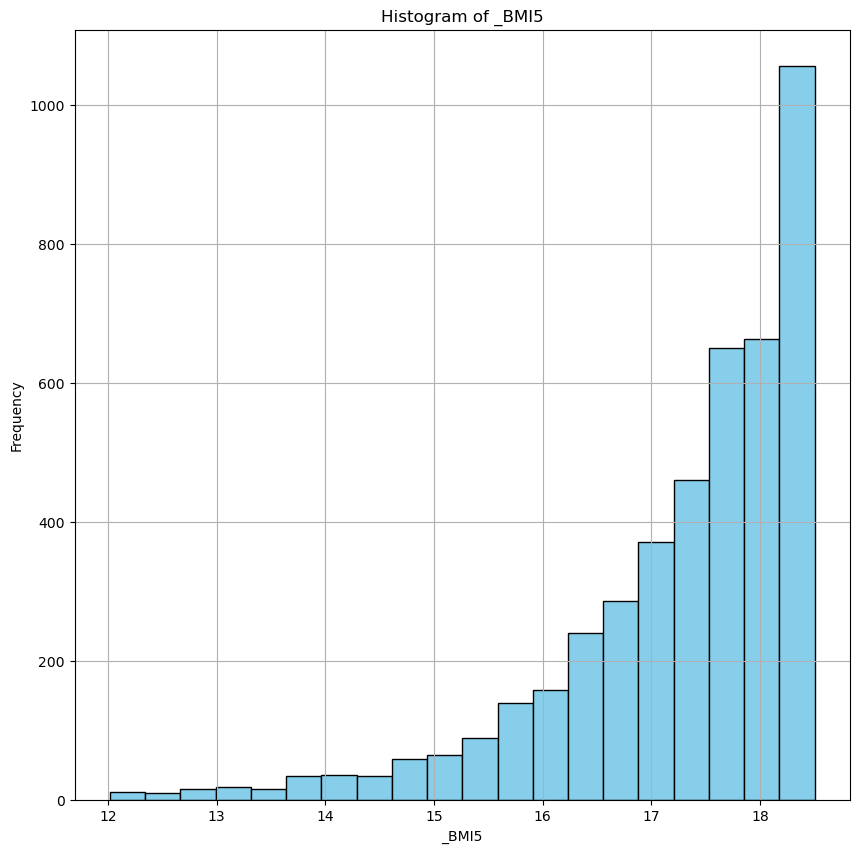

In [74]:
# Plotting Distributions for BMI

import matplotlib.pyplot as plt

column_name = '_BMI5'

# Plot histogram
plt.figure(figsize=(10, 10))
plt.hist((bmi[column_name] * 0.01), bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of ' + column_name)
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualization

- Before starting visuals, need to look back over weights and heights to potentially standarize to metric or standard measurements

- also relook at _AGEG5YR

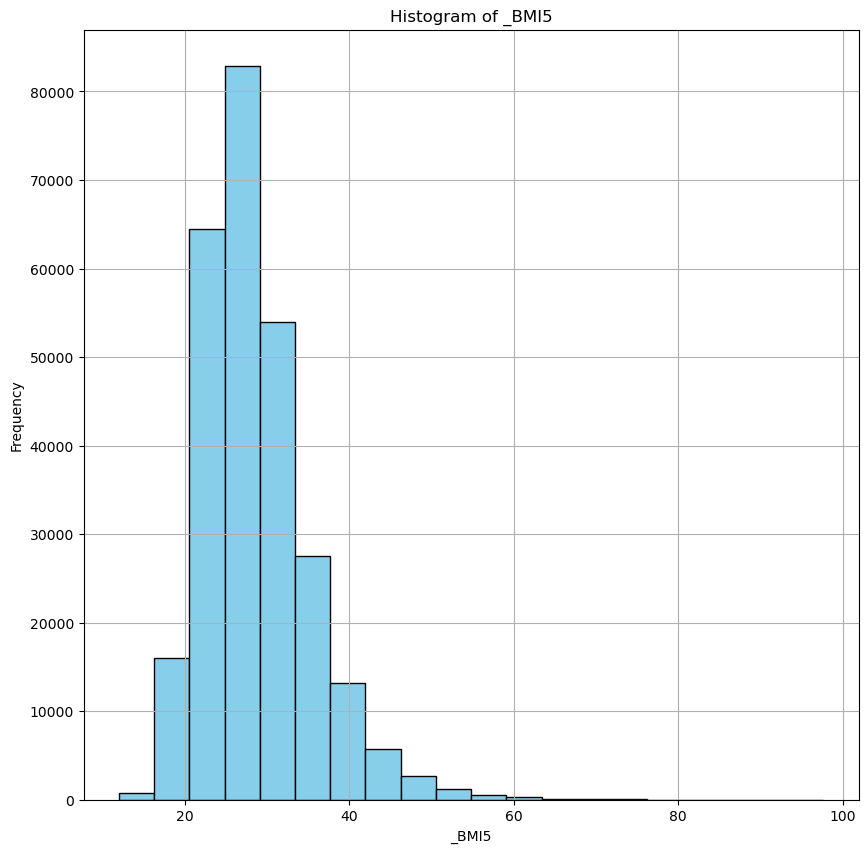

In [77]:
# Plotting Distributions for BMI

import matplotlib.pyplot as plt

column_name = '_BMI5'

# Plot histogram
plt.figure(figsize=(10, 10))
plt.hist((df_final[column_name] * 0.01), bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of ' + column_name)
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Upon observation of the distribution, it does seem to be skewed to the right. The majority of values seem to be between BMI values of 20 to 40. To be classified as overweight BMI has to be 25.0 or over and to be classified as obese BMI has to be 30.0 or over. 

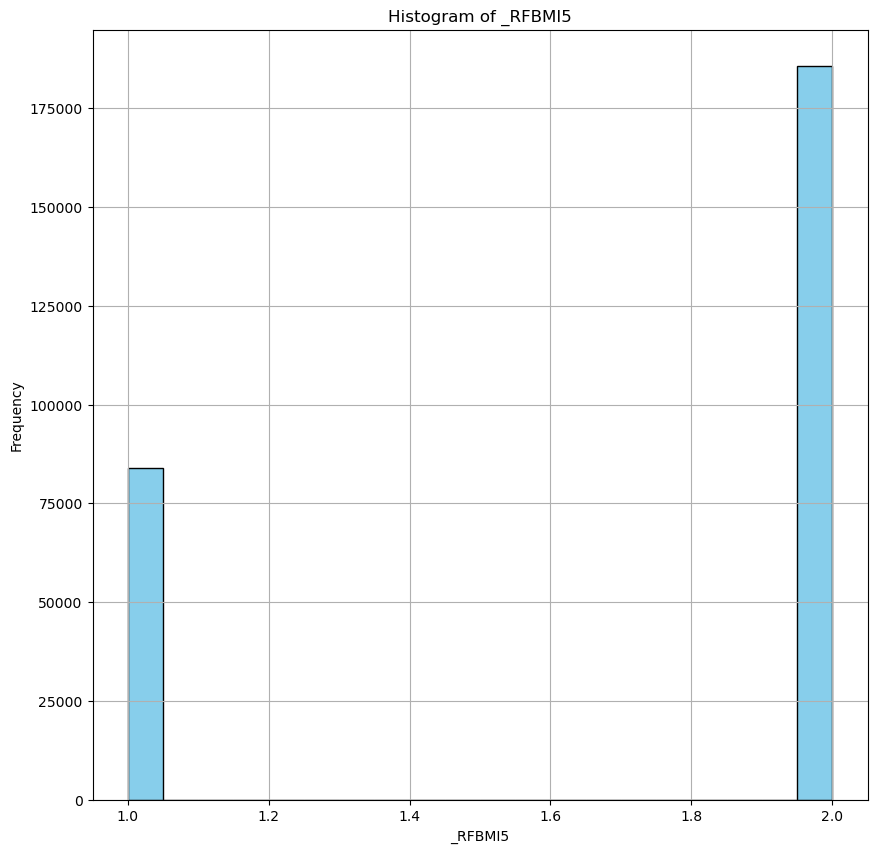

In [79]:
# Plotting Distributions for BMI

import matplotlib.pyplot as plt

column_name = '_RFBMI5'

# Plot histogram
plt.figure(figsize=(10, 10))
plt.hist((df_final[column_name] ), bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of ' + column_name)
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

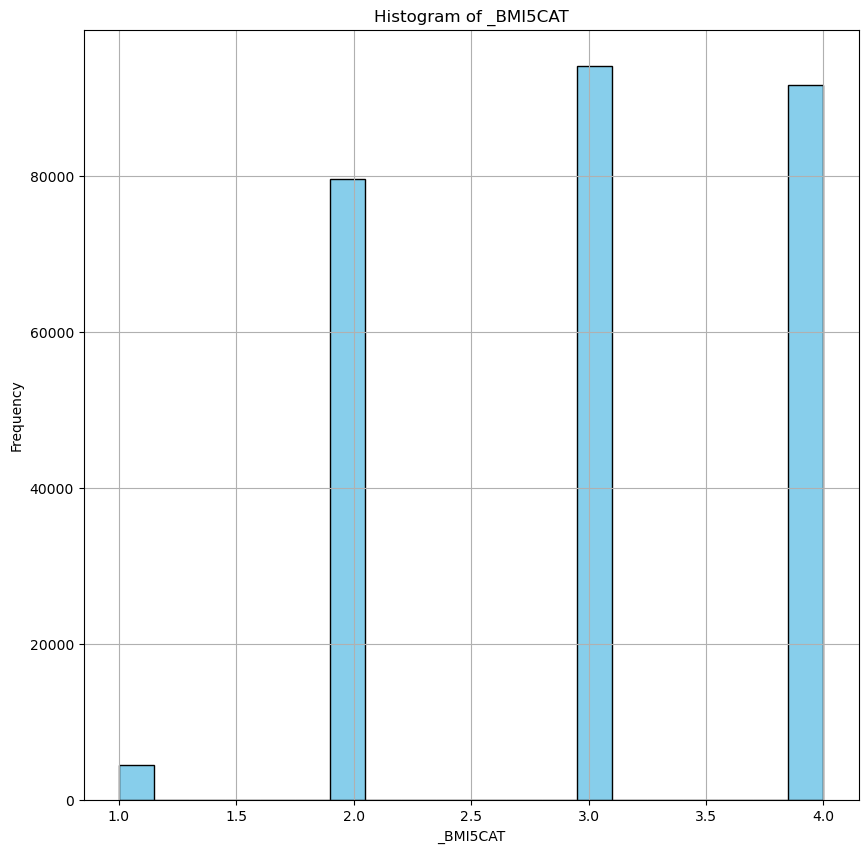

In [80]:
# Plotting Distributions for BMI

import matplotlib.pyplot as plt

column_name = '_BMI5CAT'

# Plot histogram
plt.figure(figsize=(10, 10))
plt.hist((df_final[column_name]), bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of ' + column_name)
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

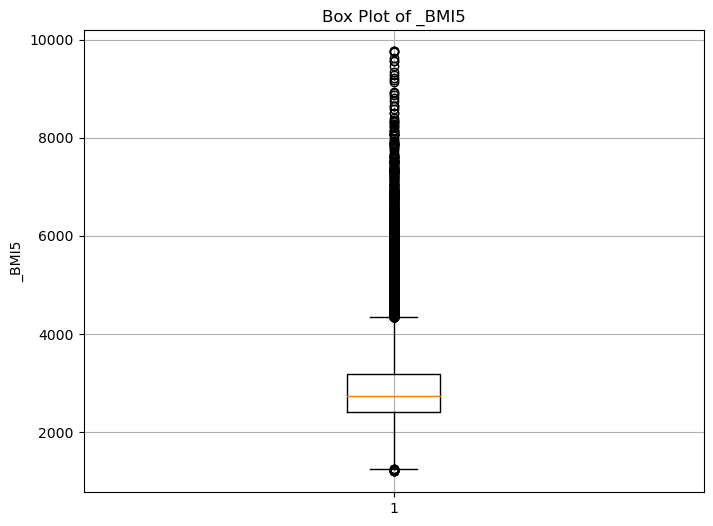

In [84]:
column_name = '_BMI5'

# Plot box plot
plt.figure(figsize=(8, 6))
plt.boxplot(df_final[column_name])
plt.title('Box Plot of ' + column_name)
plt.ylabel(column_name)
plt.grid(True)
plt.show()

_RFBMI5     1.000000
_BMI5CAT    0.855620
_BMI5       0.651032
WTKG3       0.601098
_TOTINDA    0.086805
_RFHLTH     0.069935
HTIN4       0.059009
HTM4        0.058714
_AGE_G      0.056563
WEIGHT2     0.052868
_PHYS14D    0.047833
HEIGHT3     0.046454
_METSTAT    0.032014
_AGEG5YR    0.030809
DRNKANY6    0.030692
_URBSTAT    0.027374
_RACEG22    0.021634
_IMPRACE    0.015254
_RACEGR4    0.013591
_RACE1      0.010038
_RACEPR1    0.008201
_RFBING6    0.002808
_MENT14D   -0.004372
_HLTHPLN   -0.008547
_DRNKWK2   -0.009358
_MRACE2    -0.017024
_RFDRHV8   -0.022420
_HISPANC   -0.022817
_RFSMOK3   -0.023468
_PRACE2    -0.024392
_CURECI2   -0.029778
_MICHD     -0.045258
_ASTHMS1   -0.051441
DROCDY4_   -0.060896
_DRDXAR2   -0.092527
_SEX       -0.099507
Name: _RFBMI5, dtype: float64


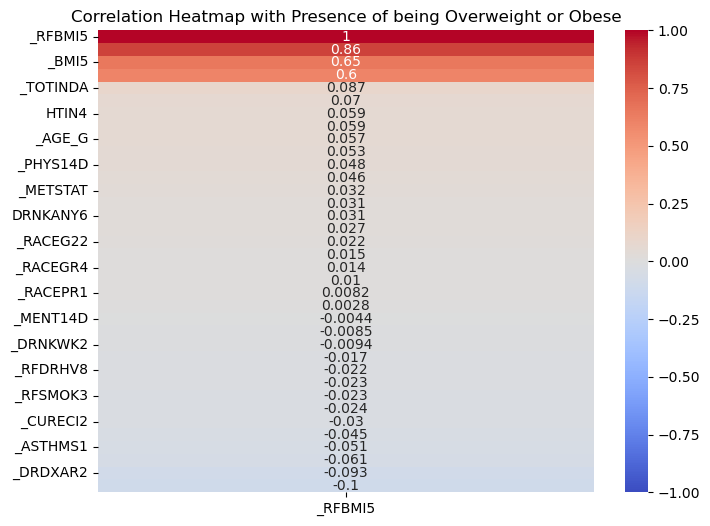

In [85]:
# Checking correlations between feature variables and target variable
print(df_final.corr()["_RFBMI5"].sort_values(ascending = False))

# Heatmap showing correlations
plt.figure(figsize=(8, 6))
sns.heatmap(df_final.corr()[['_RFBMI5']].sort_values(by='_RFBMI5', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap with Presence of being Overweight or Obese')
plt.show()


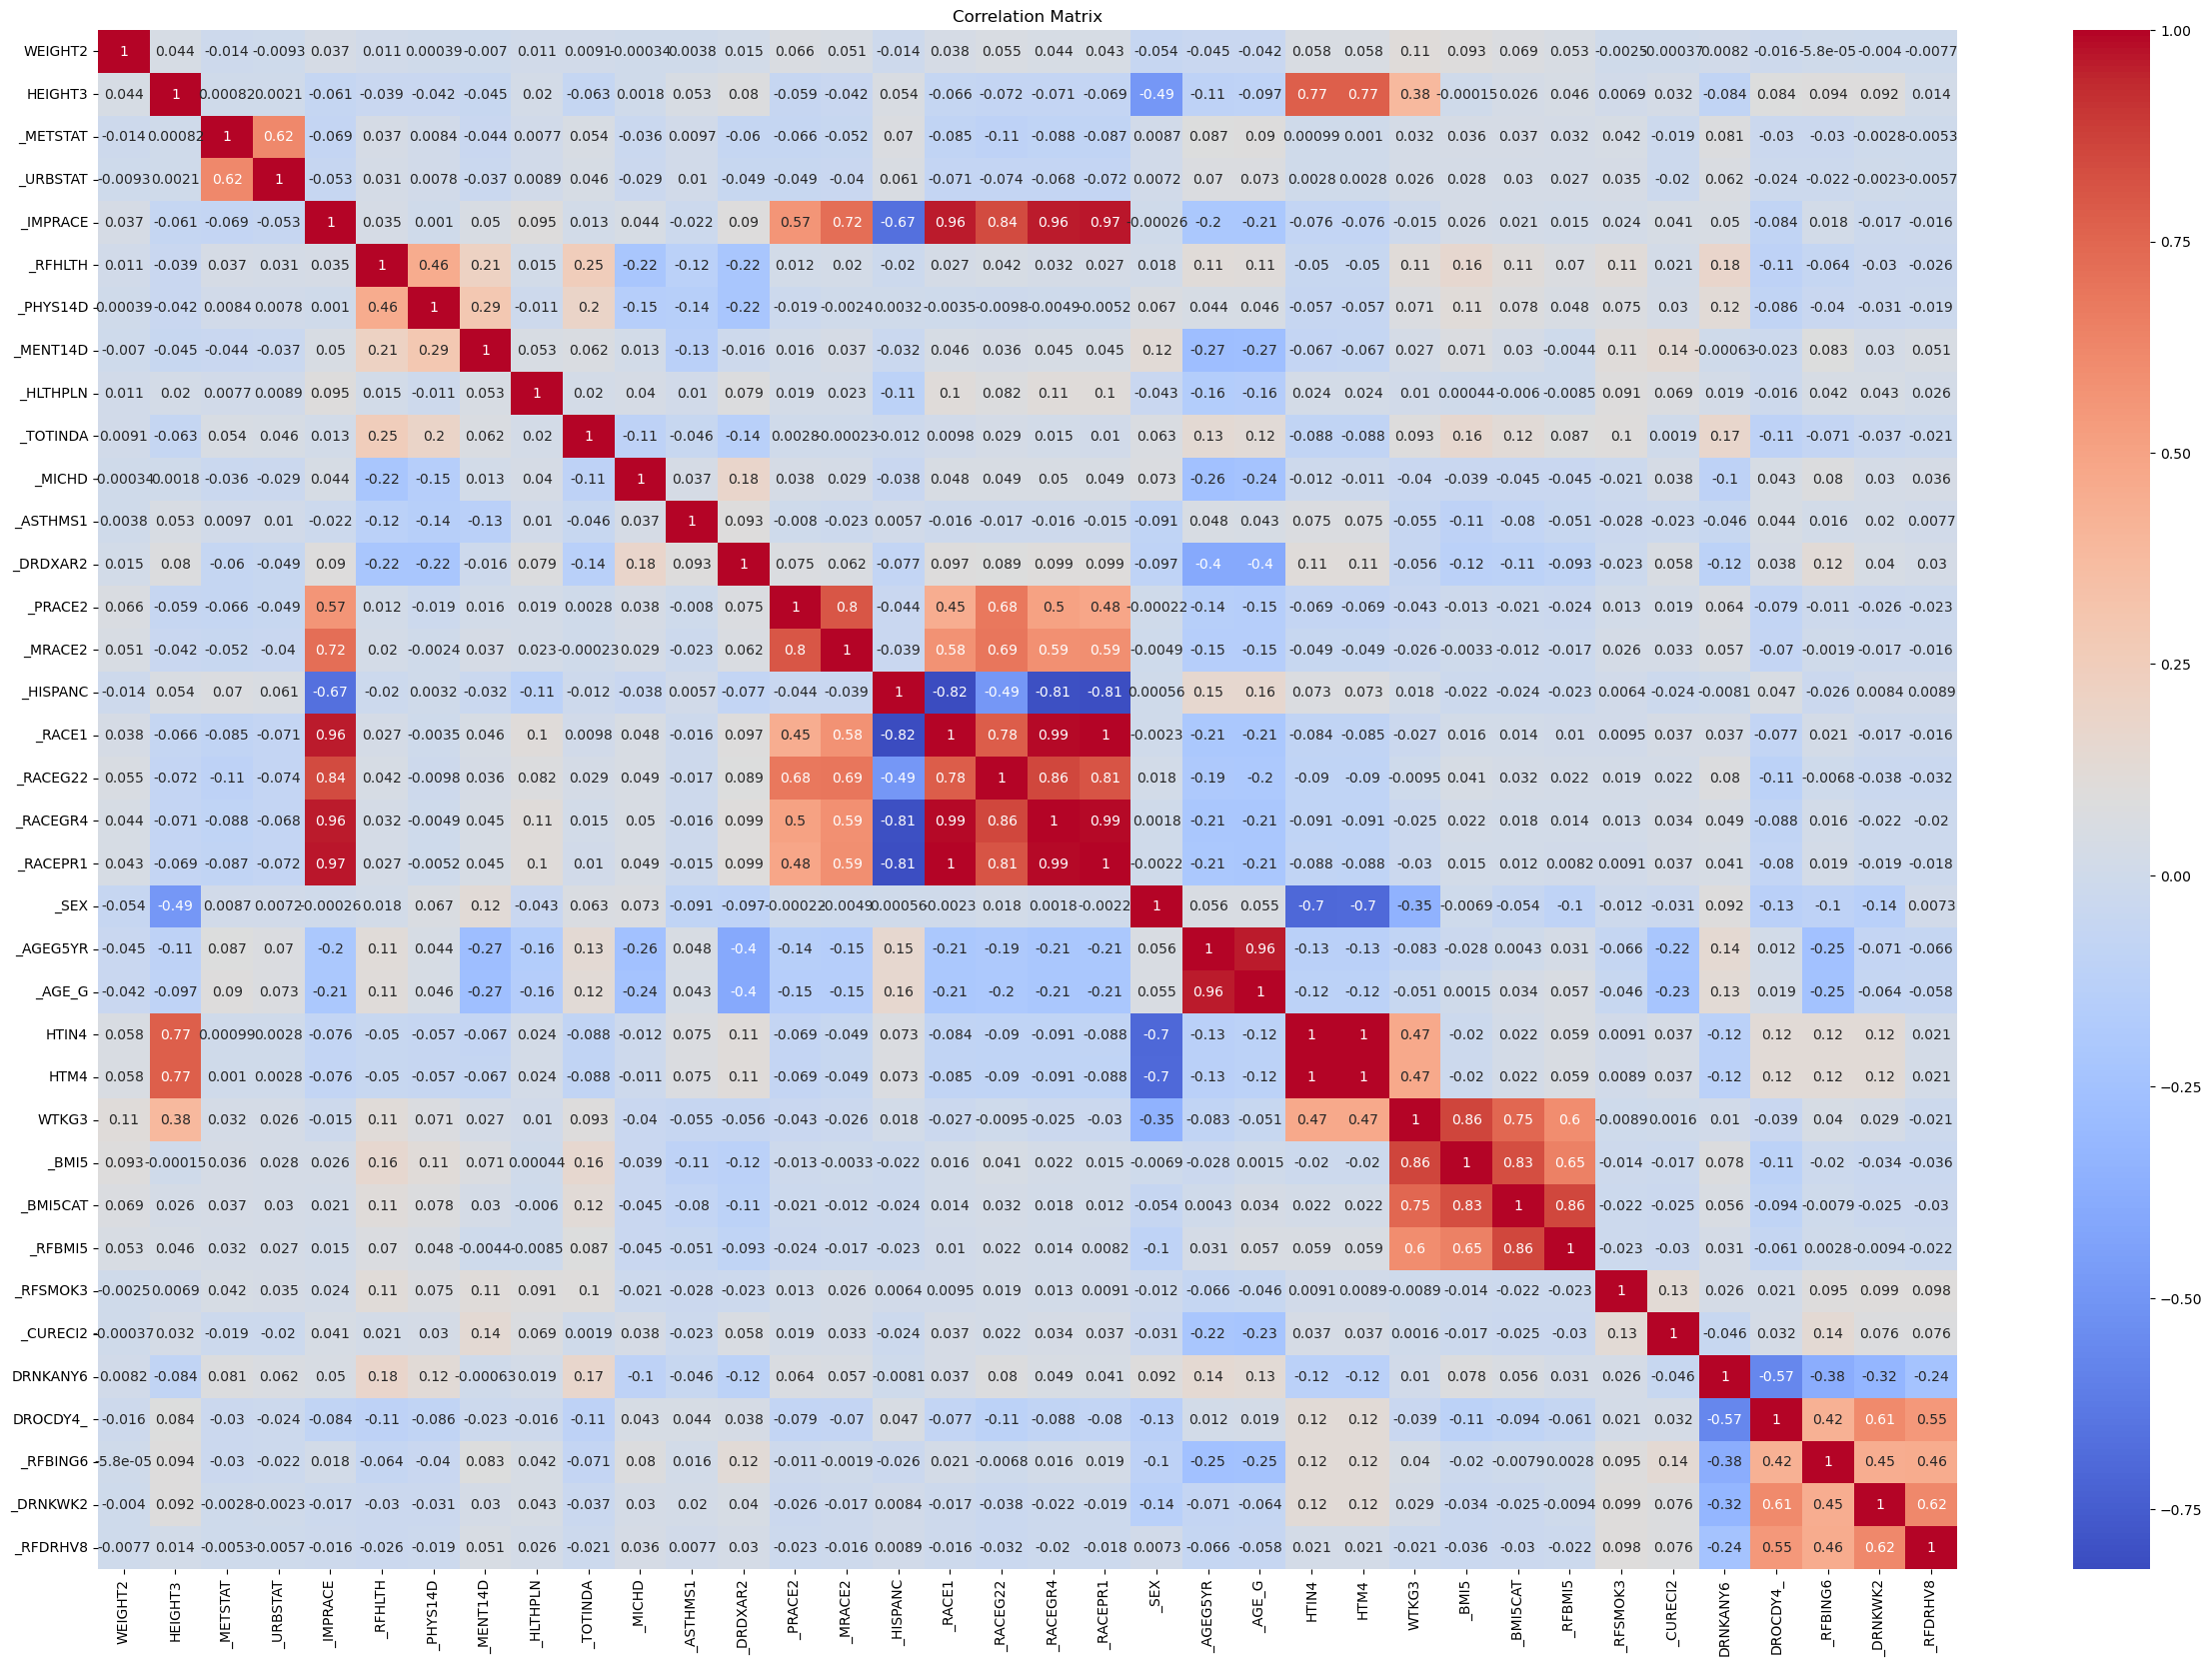

In [86]:
#Generating Correlation matrix
corr_matrix = df_final.corr()
fig, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, ax=ax)
ax.set_title('Correlation Matrix')
plt.show()

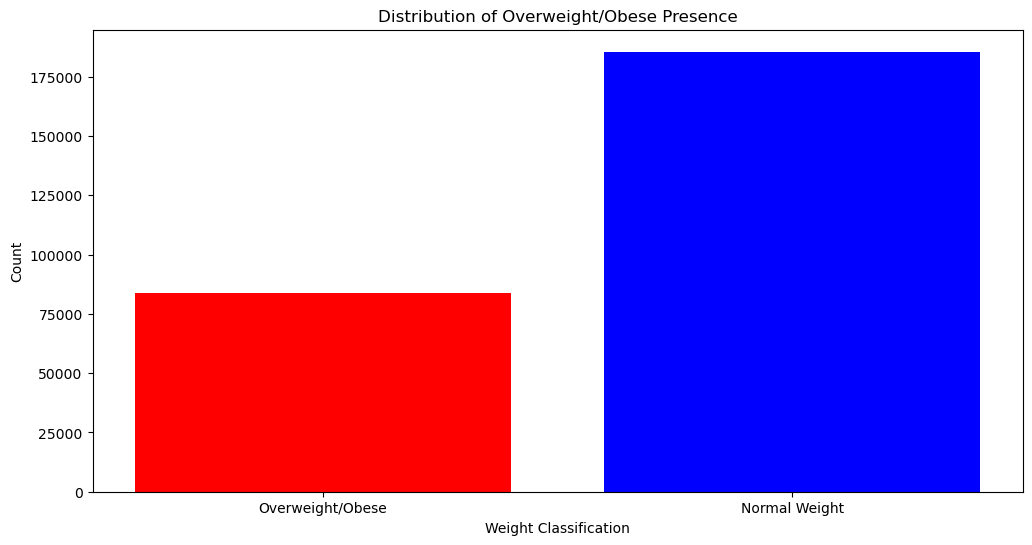

In [87]:
#Plotting visual for target variable

outcome_counts = df_final['_RFBMI5'].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(outcome_counts.index, outcome_counts.values, color=['blue', 'red'])
plt.xticks(outcome_counts.index, ['Normal Weight', 'Overweight/Obese'])
plt.xlabel('Weight Classification')
plt.ylabel('Count')
plt.title('Distribution of Overweight/Obese Presence')
plt.show()

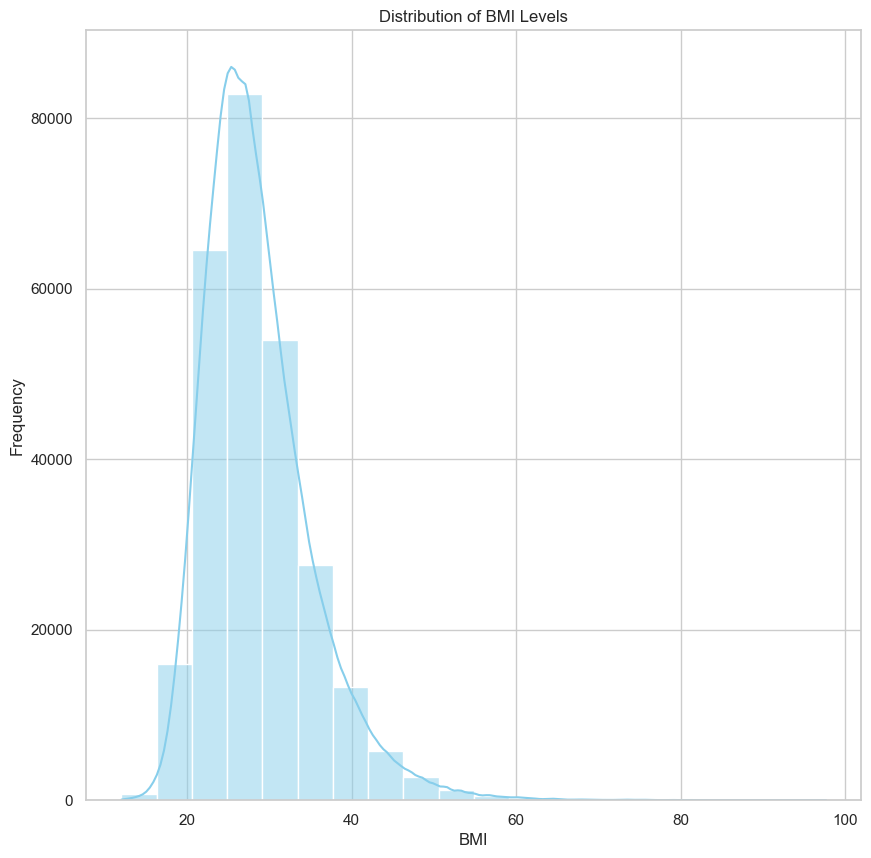

In [91]:
#Plotting a histogram to check the distribution of BMI values

sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(10, 10))
sns.histplot(data= (df_final['_BMI5'] *.01), kde=True, color='skyblue', bins=20)

# Adding title and labels 
plt.title('Distribution of BMI Levels')
plt.xlabel('BMI')
plt.ylabel('Frequency')

plt.show()

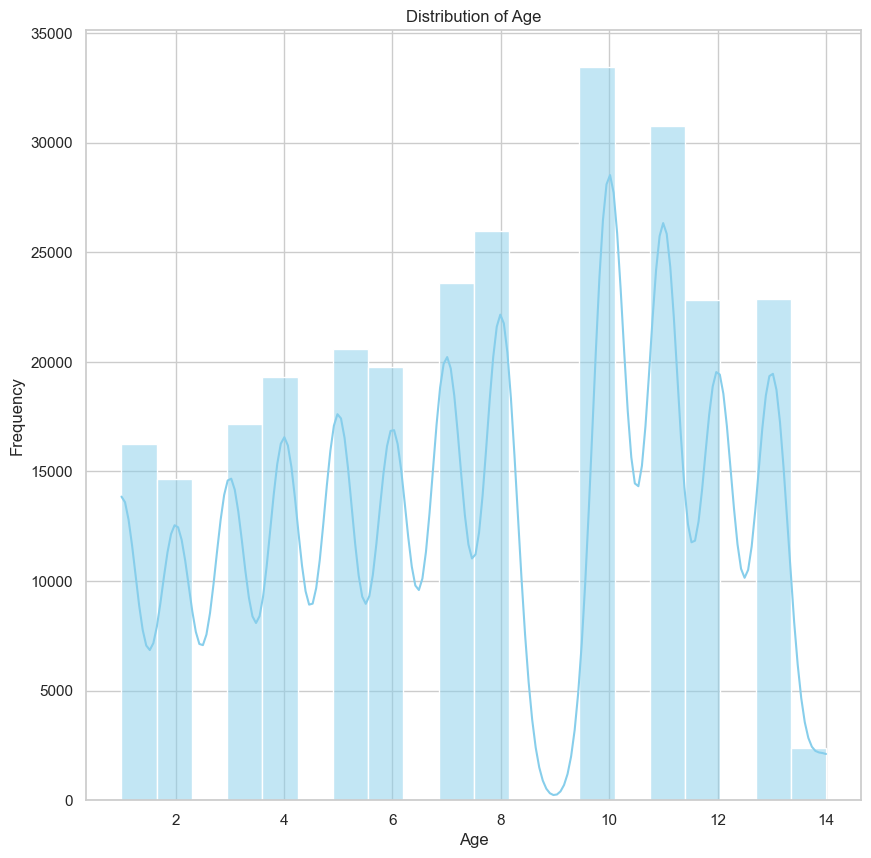

In [93]:
#Plotting a histogram to check the distribution of Age

sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(10, 10))
sns.histplot(data= df_final['_AGEG5YR'], kde=True, color='skyblue', bins=20)

# Adding title and labels 
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.show()
